# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [66]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching
import copy
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
def _return_model_features(model, inputs):
    features = dict()  # The named-hook + dict construction should be a bit more robust
    if inputs.ndim == 3:
        inputs = inputs.unsqueeze(0)

    def named_hook(name):
        def hook_fn(module, input, output):
            features[name] = input[0]
        return hook_fn
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, (torch.nn.Hardtanh)):
            hook = module.register_forward_hook(named_hook(name))
            feature_layer_name = name
            break
    model(inputs)
    hook.remove()
    return features[feature_layer_name]

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [68]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=invertinggradients',
                                                      'case=1_single_image_small'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda:2') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_image_small with server type honest_but_curious.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
restarts:
  num_trials: 1
  scoring: cosine-similarity
init: randn
optim:
  optimizer: adam
  signed: true
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: step-lr
  langevin_noise: 0.0
  warmup: 0
  callback: 1000
regularization:
  total_variation:
    scale: 0.2
    inner_exp: 1
    outer_exp: 1
  orthogonality:
    scale: 0.0



{'device': device(type='cuda', index=2), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [69]:
cfg.case.user.data_idx = 2
cfg.case.model='ConvNetSmall'

cfg.case.user.num_data_points = 10

cfg.case.data.batch_size = 512
cfg.case.server.has_external_data = True

cfg.attack.objective.type='masked-cosine-similarity'
# The total variation scale should be small for CIFAR images
cfg.attack.regularization.total_variation.scale = 1e-4
cfg.attack.init = 'randn'

cfg.attack.optim.signed=True
# cfg.attack.optim.step_size=0.01

### Instantiate all parties

In [70]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
server.model.to(**setup)

Files already downloaded and verified
Files already downloaded and verified
Model architecture <class 'breaching.cases.models.model_preparation.ConvNetSmall'> loaded with 15,355,402 parameters and 0 buffers.
Overall this is a data ratio of     500:1 for target shape [10, 3, 32, 32] given that num_queries=1.


ConvNetSmall(
  (model): Sequential(
    (conv0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu2): ReLU()
    (pool0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu3): ReLU()
    (pool1): AdaptiveAvgPool2d(output_size=1)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [71]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of data points: 10
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: ConvNetSmall
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 2
        


## Malicious server I : Modify the model architecture first

In [72]:
num_paths = 2

In [73]:
feature_dim = server.model.model[-5].out_channels
server.model.model[-1] = torch.nn.Sequential(torch.nn.Linear(feature_dim, num_paths),
                                             torch.nn.Hardtanh(min_val=0, max_val=1), 
                                             torch.nn.Linear(num_paths, feature_dim),
                                             server.model.model[-1]
                                             #torch.nn.Linear(num_paths, server.model.model[-1].out_features)
                                            ).to(**setup)


attacker.model_template = copy.deepcopy(server.model)
user.model = copy.deepcopy(server.model)
user.model

ConvNetSmall(
  (model): Sequential(
    (conv0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu2): ReLU()
    (pool0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu3): ReLU()
    (pool1): AdaptiveAvgPool2d(output_size=1)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=2, bias=True)
      (1): Hardtanh(min_val=0, max_val=1)
      (2): Linear(in_features=2, out_features=1024, bias=True)
      (3): Linear(in_features=1024, out_features=10, bias=True)
    )
  )
)

## Malicious server II: Include paths

In [74]:
# Old first layer:
# new_weight = module.weight.new_zeros(module.in_channels, module.in_channels, *module.kernel_size)
# torch.nn.init.orthogonal_(new_weight)
# new_bias = module.bias.new_zeros(module.in_channels)
# fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(new_weight)
# torch.nn.init.uniform_(new_bias, -1 / math.sqrt(fan_in), 1 / math.sqrt(fan_in))

# # Replicate filters:
# replication_dim = module.out_channels // module.in_channels
# replicated_weight = torch.cat([new_weight] * replication_dim).contiguous()
# replicated_bias = torch.cat([new_bias] * replication_dim).contiguous()

# module.weight.data[:replication_dim * module.in_channels] = replicated_weight
# module.bias.data[:replication_dim * module.in_channels] = replicated_bias

In [75]:
input_path_width = 3
first_conv = True
with torch.no_grad():
    for name, module in server.model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            # Initialize existing params at zero:
            module.weight.data = torch.zeros_like(module.weight)
            module.bias.data = torch.zeros_like(module.bias)
            
            output_path_width = module.out_channels // num_paths
            
            new_weight = module.weight.new_zeros(output_path_width, input_path_width,  *module.kernel_size)
            torch.nn.init.orthogonal_(new_weight)

            new_bias = module.bias.new_zeros(output_path_width)
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(new_weight)
            torch.nn.init.uniform_(new_bias, -1 / math.sqrt(fan_in), 1 / math.sqrt(fan_in))

            # Group channels:
            ii, io = 0, 0 # index-in index-out
            if first_conv:
                for path in range(num_paths):
                    module.weight.data[io:io+output_path_width, :] = new_weight.clone()
                    io += output_path_width
                    ii += input_path_width
                first_conv = False
            else:
                for path in range(num_paths):
                    module.weight.data[io:io+output_path_width, ii:ii+input_path_width] = new_weight.clone()
                    io += output_path_width
                    ii += input_path_width
                
            module.bias.data[:output_path_width * num_paths] = torch.cat([new_bias] * num_paths).contiguous()
            
            # Set input->output
            input_path_width = output_path_width
            
            
            print(module.weight.shape, module.bias.shape)
            # Test channel:
            inputs = torch.cat([torch.randn(1, 1, 32, 32, **setup)] * module.in_channels, dim=1)
            feats = module(inputs)
            print(feats[0,0:4, 0, 0], feats[0,output_path_width:output_path_width+4, 0, 0])
        if isinstance(module, torch.nn.Linear) and module.out_features == num_paths:
            # prep averaging layer here
            module.weight.data = torch.zeros_like(module.weight.data)
            module.bias.data = torch.zeros_like(module.bias.data)
            new_block = module.weight.data.new_zeros(input_path_width) / input_path_width
            # new_block[0] = 1
            torch.nn.init.uniform_(new_block)
            idx = 0
            for path in range(num_paths):
                module.weight.data[path, idx:idx+input_path_width] = new_block.clone()
                idx += input_path_width
            adaptation_layer = module
        if isinstance(module, torch.nn.Linear) and module.in_features == num_paths:
            # prep return layer here, all inputs need to be picked up
            module.weight.data = torch.ones_like(module.weight.data) 
            torch.nn.init.orthogonal_(module.weight.data) * num_paths**2
            module.bias.data = torch.zeros_like(module.bias.data)
            # pass
            # dont mess with the return layer
            
num_params = sum([(p.abs() > 1e-7).sum() for p in server.model.parameters()])
linear_params = sum([(p.abs() > 1e-7).sum() for m in server.model.modules() for p in m.parameters()  
                     if isinstance(m, torch.nn.Linear)])
print(f'Model architecture {server.model.__class__} loaded with {num_params:,} non-zero parameters of which '
      f'{linear_params} are in linear layers.')

target_information = cfg.case.user.num_data_points * torch.as_tensor(cfg.case.data.shape).prod()

print(f'Overall this is a data ratio of {(num_params - linear_params) / target_information:2.2f}:1 '
      f'for target shape {[cfg.case.user.num_data_points, *cfg.case.data.shape]} if pathcount was optimal.')

torch.Size([256, 3, 3, 3]) torch.Size([256])
tensor([ 0.0560, -0.1214,  0.6884, -0.2748], device='cuda:2') tensor([ 0.0560, -0.1214,  0.6884, -0.2748], device='cuda:2')
torch.Size([512, 256, 3, 3]) torch.Size([512])
tensor([ 0.3324, -1.0259,  0.6174, -0.4959], device='cuda:2') tensor([ 0.3324, -1.0259,  0.6174, -0.4959], device='cuda:2')
torch.Size([1024, 512, 3, 3]) torch.Size([1024])
tensor([ 0.8907,  1.4881, -0.8120, -0.2674], device='cuda:2') tensor([ 0.8907,  1.4881, -0.8120, -0.2674], device='cuda:2')
torch.Size([1024, 1024, 3, 3]) torch.Size([1024])
tensor([ 1.0678, -0.4186, -0.0643, -0.6064], device='cuda:2') tensor([ 1.0678, -0.4186, -0.0643, -0.6064], device='cuda:2')
Model architecture <class 'breaching.cases.models.model_preparation.ConvNetSmall'> loaded with 7,690,722 non-zero parameters of which 13322 are in linear layers.
Overall this is a data ratio of 249.92:1 for target shape [10, 3, 32, 32] if pathcount was optimal.


In [76]:
inputs = torch.randn(1, 3, 32, 32, **setup)
feats = _return_model_features(server.model, inputs)
feats

tensor([[24.0983, 24.0983]], device='cuda:2', grad_fn=<AddmmBackward>)

# Compute bins and set feature distribution:

In [77]:
from statistics import NormalDist

def get_bins_by_mass(num_bins, mu=0, sigma=1):
    bins = []
    mass = 0
    for path in range(num_bins + 1):
        mass += 1 / (num_bins + 2)
        bins += [NormalDist(mu=mu, sigma=sigma).inv_cdf(mass)]
    bin_sizes = [bins[i + 1] - bins[i] for i in range(len(bins) - 1)]
    return bins[:-1], bin_sizes

In [78]:
get_bins_by_mass(1)

([-0.43072729929545744], [0.8614545985909148])

In [79]:
features = dict()
def named_hook(name):
    def hook_fn(module, input, output):
        features[name] = output
    return hook_fn

In [80]:
with torch.inference_mode():
    for name, module in server.model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            hook = module.register_forward_hook(named_hook(name))

            random_data_sample = next(iter(server.external_dataloader))[0].to(**setup)
            # random_data_sample = torch.randn(1024, 3, 32, 32, **setup)
            # random_data_sample = true_user_data['data'] #ground truth data sampâle for testing

            server.model(random_data_sample)
            std, mu = torch.std_mean(features[name])
            print(f'Initial mean of layer {name} is {mu.item()}, std is {std.item()}')
            
            with torch.no_grad():
                module.weight.data /= std + 1e-8
                module.bias.data -= mu / (std  + 1e-8)

            server.model(random_data_sample)
            std, mu = torch.std_mean(features[name])
            print(f'Fixed mean of layer {name} is {mu.item()}, std is {std.item()}')  
            hook.remove()
            
            if isinstance(module, torch.nn.Linear) and module.out_features == num_paths:
                # Verify:
                print(f'Input to hardtanh before bias and scale is set: {features[name][0]}')

                adapt_module = module
                # Modify bins in this layer
                bins, bin_sizes = get_bins_by_mass(num_paths, mu=mu, sigma=std)
                # Safety wheels:
                #bins = [b * 2 for b in bins]
                #bin_sizes = [b * 2 for b in bin_sizes]
                #bins = torch.linspace(-1.96, 1.96, num_paths + 1)
                #bin_sizes = [bins[i + 1] - bins[i] for i in range(len(bins) - 1)]
                #bins = bins[:-1]
                
                # Old mod:
                module.weight.data /= torch.as_tensor(bin_sizes, **setup)[:, None]
                module.bias.data -= torch.as_tensor(bins, **setup)
                module.bias.data /= torch.as_tensor(bin_sizes, **setup)

                # New computation with extend bin extension?:
#                 I = -NormalDist(mu=0, sigma=1).inv_cdf(0.90)
#                 module.weight.data *= 2 * I / torch.as_tensor(bin_sizes, **setup)[:, None]
#                 module.bias.data -= torch.as_tensor(bins, **setup) 
#                 module.bias.data *= 2 * I / torch.as_tensor(bin_sizes, **setup)
#                 module.bias.data -= I
                hook.remove()
                break
            del features[name]

Initial mean of layer model.conv0 is 0.017847325652837753, std is 0.46087440848350525
Fixed mean of layer model.conv0 is -0.021574057638645172, std is 0.9756867289543152
Initial mean of layer model.conv1 is -0.02118159644305706, std is 0.6817082762718201
Fixed mean of layer model.conv1 is 0.00017898529767990112, std is 0.9994403719902039
Initial mean of layer model.conv2 is 0.01639900915324688, std is 0.6921842098236084
Fixed mean of layer model.conv2 is 0.0002770647406578064, std is 0.9999733567237854
Initial mean of layer model.conv3 is -0.01010180450975895, std is 0.8421465158462524
Fixed mean of layer model.conv3 is -1.9515240637701936e-05, std is 0.9999127388000488
Initial mean of layer model.linear.0 is 96.9615707397461, std is 22.955591201782227
Fixed mean of layer model.linear.0 is -1.2293457984924316e-07, std is 0.9999999403953552
Input to hardtanh before bias and scale is set: tensor([-0.4093, -0.4093], device='cuda:2')


In [81]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

In [82]:
with torch.inference_mode():
    hook = adapt_module.register_forward_hook(named_hook('hardtanh_input'))
    # random_data_sample = next(iter(server.external_dataloader))[0].to(**setup)
    # random_data_sample = torch.randn(1024, 3, 32, 32, **setup)
    random_data_sample = true_user_data['data'] #ground truth data sample for testing

    server.model(random_data_sample)
    hook.remove()

In [83]:
print(features['hardtanh_input'][0])
threshold = torch.nn.functional.hardtanh(features['hardtanh_input'][0], min_val=0, max_val=1)
print(threshold)

tensor([1.2222, 0.2222], device='cuda:2')
tensor([1.0000, 0.2222], device='cuda:2')


### Threshold stats:

In [84]:
threshold = torch.nn.functional.hardtanh(features['hardtanh_input'], min_val=0, max_val=1)
print(((threshold != 1) & (threshold != 0)).sum() / random_data_sample.shape[0])
((threshold != 1) & (threshold != 0)).sum(dim=0)

tensor(0.6000, device='cuda:2')


tensor([4, 2], device='cuda:2')

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [85]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

true_user_data['data'].mean(), true_user_data['data'].std()

(tensor(-0.1558, device='cuda:2'), tensor(0.9794, device='cuda:2'))

In [86]:
[(g[g.abs() > 1e-6].mean(), g[g.abs() > 1e-6].std()) for g in shared_data['gradients'][0]]

[(tensor(1.9253e-05, device='cuda:2'), tensor(6.9161e-05, device='cuda:2')),
 (tensor(-4.7567e-05, device='cuda:2'), tensor(6.2125e-05, device='cuda:2')),
 (tensor(-1.0954e-05, device='cuda:2'), tensor(2.3122e-05, device='cuda:2')),
 (tensor(-2.5684e-05, device='cuda:2'), tensor(3.5907e-05, device='cuda:2')),
 (tensor(-7.1977e-06, device='cuda:2'), tensor(1.5678e-05, device='cuda:2')),
 (tensor(-1.4010e-05, device='cuda:2'), tensor(2.3743e-05, device='cuda:2')),
 (tensor(-1.5240e-05, device='cuda:2'), tensor(1.7984e-05, device='cuda:2')),
 (tensor(-2.6770e-05, device='cuda:2'), tensor(2.4686e-05, device='cuda:2')),
 (tensor(-0.0006, device='cuda:2'), tensor(0.0006, device='cuda:2')),
 (tensor(-0.0015, device='cuda:2'), tensor(0.0008, device='cuda:2')),
 (tensor(0.0001, device='cuda:2'), tensor(0.0040, device='cuda:2')),
 (tensor(5.0643e-05, device='cuda:2'), tensor(0.0058, device='cuda:2')),
 (tensor(6.1154e-11, device='cuda:2'), tensor(0.0030, device='cuda:2')),
 (tensor(-5.9605e-09, 

In [87]:
# Sparsity:
(shared_data['gradients'][0][0].abs() > 1e-8).sum() / shared_data['gradients'][0][0].numel()

tensor(0.9999, device='cuda:2')

In [88]:
torch.stack([g.pow(2).sum() for g in shared_data['gradients'][0][:-4]]).sum().sqrt()

tensor(0.0793, device='cuda:2')

In [89]:
results = breaching.analysis.metrics.gradient_uniqueness(user.model, user.loss, true_user_data, 
                                                            server_payload, setup, fudge=1e-5)
unique_entries, average_hits_per_entry, nonzero_uniques, nonzero_hits_per_entry, uniques, uniques_nonzero = results
print(f'Unique entries (hitting 1 or all): {unique_entries:.2%}, average hits: {average_hits_per_entry:.2%} \n'
      f'Stats (as N hits:val): {dict(zip(uniques[0].tolist(), uniques[1].tolist()))}\n'
      f'Unique nonzero (hitting 1 or all): {nonzero_uniques:.2%} Average nonzero: {nonzero_hits_per_entry:.2%}. \n'
      f'nonzero-Stats (as N hits:val): {dict(zip(uniques_nonzero[0].tolist(), uniques_nonzero[1].tolist()))}')

Unique entries (hitting 1 or all): 37.69%, average hits: 665.11% 
Stats (as N hits:val): {0: 3404408, 1: 772069, 2: 72883, 3: 3362, 4: 5, 5: 6, 6: 258319, 7: 881872, 8: 1211209, 9: 3739839, 10: 5016552}
Unique nonzero (hitting 1 or all): 18.15% Average nonzero: 21.82%. 
nonzero-Stats (as N hits:val): {0: 3404405, 1: 772069, 2: 72856, 3: 3345}


{0: 4873983, 1: 8396, 2: 110, 7: 140, 8: 5991, 9: 12410, 10: 10475886}


['ship', 'dog', 'deer', 'deer', 'dog', 'airplane', 'frog', 'ship', 'automobile', 'ship']


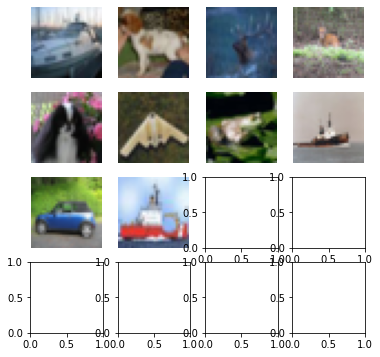

In [24]:
user.plot(true_user_data)

### Reconstruct user data:

In [25]:
#attacker.model_template.model.linear[1] = torch.nn.Identity()


attacker.objective.scale = ((shared_data['gradients'][0][0].abs() > 1e-8).sum() 
                            / shared_data['gradients'][0][0].numel())
attacker.model_template

ConvNetSmall(
  (model): Sequential(
    (conv0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu2): ReLU()
    (pool0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu3): ReLU()
    (pool1): AdaptiveAvgPool2d(output_size=1)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=10, bias=True)
      (1): Hardtanh(min_val=0, max_val=1)
      (2): Linear(in_features=10, out_features=1024, bias=True)
      (3): Linear(in_features=1024, out_features=10, bias=True)
    )
  )
)

In [ ]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

It: 1. Rec. loss: 0.3430. T: 0.14s
It: 1001. Rec. loss: 0.1920. T: 65.19s
It: 2001. Rec. loss: 0.1845. T: 70.44s
It: 3001. Rec. loss: 0.1394. T: 73.48s
It: 4001. Rec. loss: 0.2798. T: 73.21s
It: 5001. Rec. loss: 0.1927. T: 73.88s
It: 6001. Rec. loss: 0.1789. T: 74.14s
It: 7001. Rec. loss: 0.2541. T: 74.18s
It: 8001. Rec. loss: 0.1316. T: 74.22s
It: 9001. Rec. loss: 0.3594. T: 74.20s
It: 10001. Rec. loss: 0.2867. T: 74.22s
It: 11001. Rec. loss: 0.1867. T: 74.19s
It: 12001. Rec. loss: 0.1816. T: 74.23s
It: 13001. Rec. loss: 0.2022. T: 74.21s
It: 14001. Rec. loss: 0.2630. T: 74.20s
It: 15001. Rec. loss: 0.1798. T: 74.21s
It: 16001. Rec. loss: 0.3294. T: 74.23s
It: 17001. Rec. loss: 0.1998. T: 74.23s
It: 18001. Rec. loss: 0.1991. T: 74.24s
It: 19001. Rec. loss: 0.1988. T: 74.23s
It: 20001. Rec. loss: 0.1991. T: 74.22s
It: 21001. Rec. loss: 0.2845. T: 74.20s
It: 22001. Rec. loss: 0.1992. T: 74.20s
It: 23001. Rec. loss: 0.1987. T: 74.19s


['airplane', 'ship', 'dog', 'deer', 'frog', 'ship', 'ship', 'deer', 'automobile', 'dog']


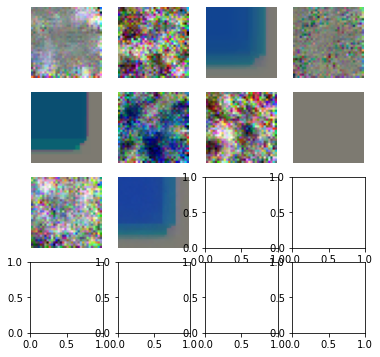

In [29]:
user.plot(reconstructed_user_data, scale=False)

In [ ]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=True)